# 1. Importing the Raman Analyzer Module
In this section, we import our custom `RamanAnalyzer` module (shortened to `ra`), which contains 
all the functions needed for reading, baseline-correcting, and fitting Raman spectra. 
We also use `importlib.reload(ra)` to ensure that any recent changes to the code are updated
without having to restart the kernel.

In [1]:
# Import the Raman Analyzer module
import RamanAnalyzer as ra

# Reload the module to get the latest changes
import importlib
importlib.reload(ra)

<module 'RamanAnalyzer' from '/Users/mykytakizilov/Dropbox/projects/BMEN/Raman-Spectra-Analyzer/RamanAnalyzer.py'>

# 2. Parsing Files from the Dataset
Here we parse the CSV file containing our Teflon Raman data. The CSV is expected to have 
a header row (which we skip by default) and multiple columns: 
- The first column is "Wavenumber" (or wavelength), 
- The subsequent columns are intensities from different rounds of imaging.

The function `raman_parser` returns a list of DataFrames, where each DataFrame corresponds
to one column of intensity data.


In [2]:
teflon_df = ra.raman_parser('data/teflon.csv')

# 3. Exploring the Parsed Data
After parsing, `teflon_df` is a *list* of DataFrames. Each DataFrame in the list
represents one individual Raman measurement (or one “round” of imaging).
Below, we check the list length and display one DataFrame to see its structure.

In [3]:
print(len(teflon_df))
display(teflon_df[0])

4


,Wavenumber,Intensity
0,256.836,30292
1,256.867,29096
2,256.899,28380
3,256.930,27405
4,256.961,26453
...,...,...
1019,287.799,7382
1020,287.828,7588
1021,287.857,7406
1022,287.887,7503


# 4. Visualizing a Single Teflon Spectrum
To get a sense of what the raw Teflon data looks like, we plot one of the DataFrames.

/Users/mykytakizilov/Dropbox/projects/BMEN/Raman-Spectra-Analyzer/RamanAnalyzer.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


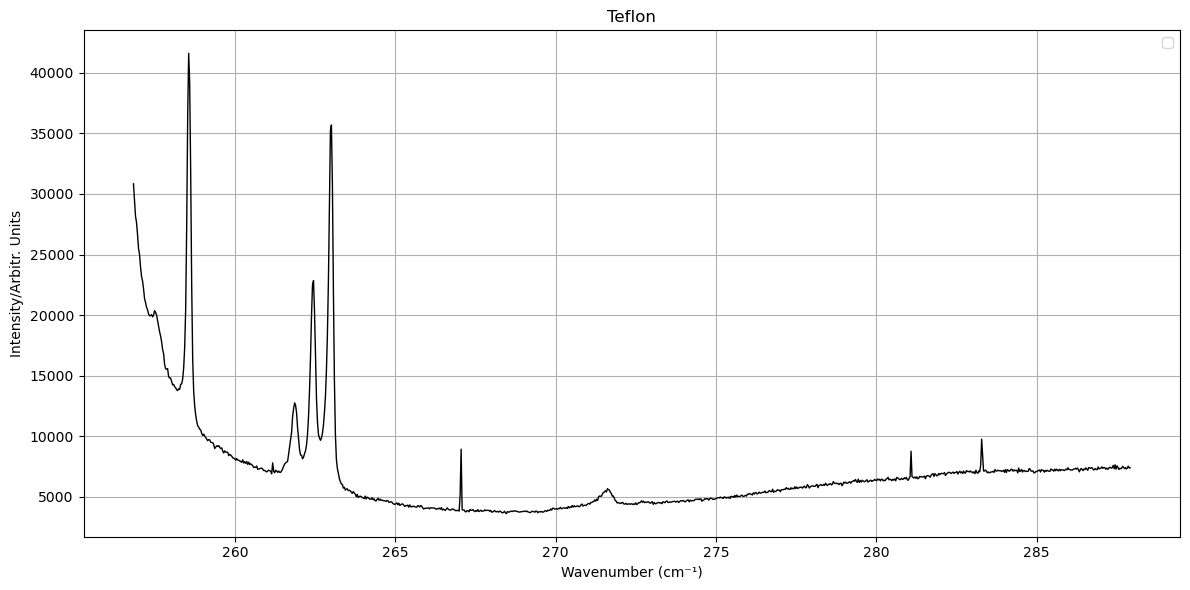

In [4]:
ra.plot_raman(teflon_df[1], 'Teflon')

# 5. Removing Spikes (Despiking)
Cosmic rays or other sudden spike artifacts can appear in the Raman spectrum, 
producing outlier points. We use the `despike_raman` function with a modified Z-score approach 
to remove these spikes. 

Here, we choose a threshold of 11 for the modified Z-score and a moving_average window of 2. 
The threshold should be set high enough to ignore normal noise but low enough to catch spikes.

/Users/mykytakizilov/Dropbox/projects/BMEN/Raman-Spectra-Analyzer/RamanAnalyzer.py:285: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15479.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  y_out[i] = np.median(y_values[we])
/Users/mykytakizilov/Dropbox/projects/BMEN/Raman-Spectra-Analyzer/RamanAnalyzer.py:285: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '29500.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  y_out[i] = np.median(y_values[we])


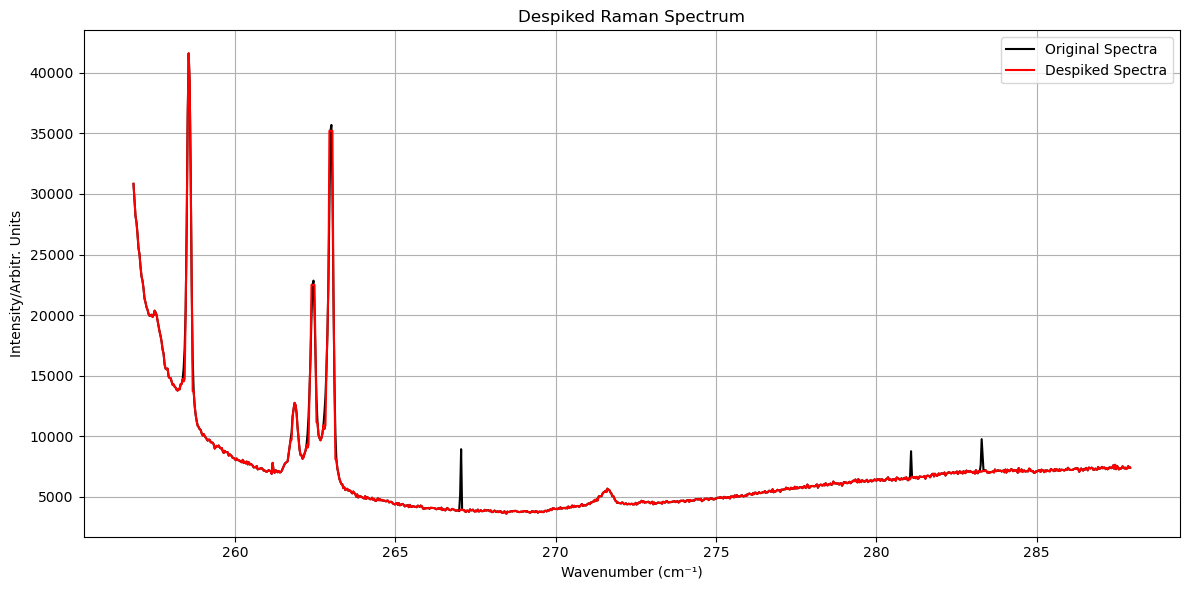

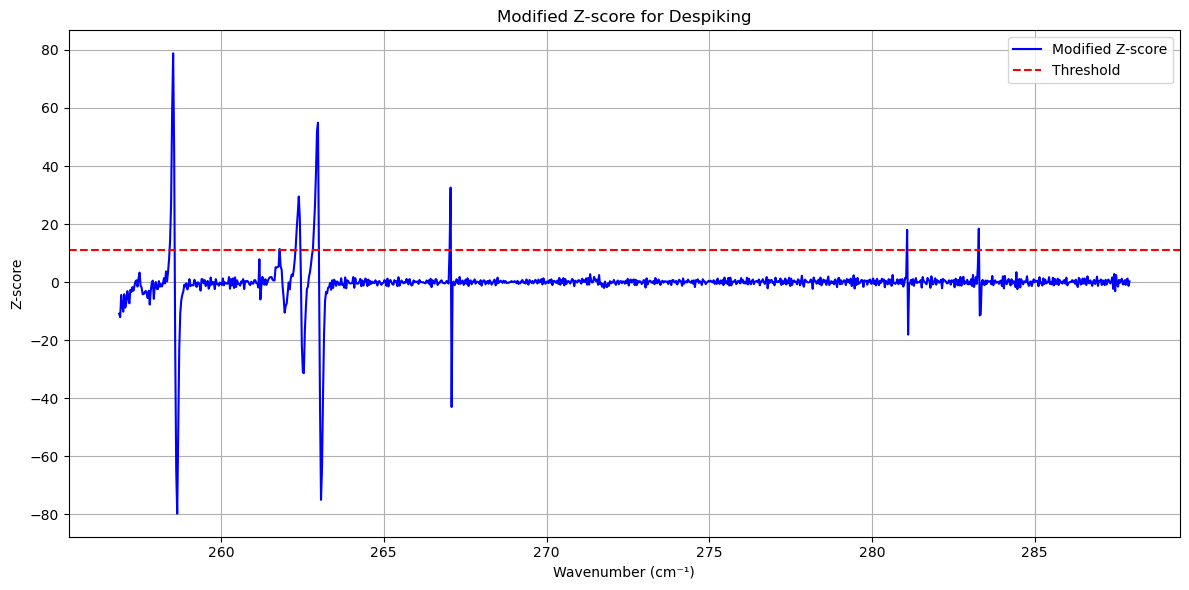

/Users/mykytakizilov/Dropbox/projects/BMEN/Raman-Spectra-Analyzer/RamanAnalyzer.py:285: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9130.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  y_out[i] = np.median(y_values[we])
/Users/mykytakizilov/Dropbox/projects/BMEN/Raman-Spectra-Analyzer/RamanAnalyzer.py:285: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14762.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  y_out[i] = np.median(y_values[we])


In [5]:
teflon_despiked = list(range(4))
teflon_despiked[0] = ra.despike_raman(teflon_df[0], moving_average=2, threshold=11)
teflon_despiked[1] = ra.despike_raman(teflon_df[1], moving_average=2, threshold=11, plot=True)
teflon_despiked[2] = ra.despike_raman(teflon_df[2], moving_average=2, threshold=11)
teflon_despiked[3] = ra.despike_raman(teflon_df[3], moving_average=2, threshold=11)


# 6. Averaging Despiked DataFrames
We may have multiple Teflon spectra from repeated measurements. Averaging these 
improves the signal-to-noise ratio (SNR). The `average_raman` function handles possible 
differences in wavenumber resolution between DataFrames by interpolating them 
to a common grid before averaging.


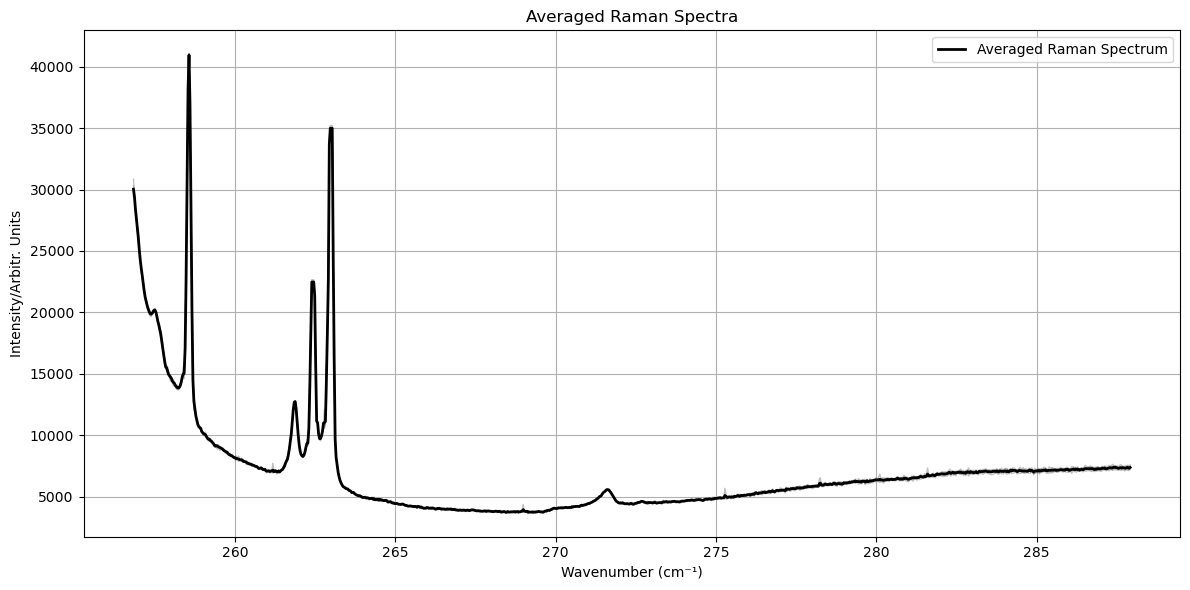

In [6]:
teflon_averaged = ra.average_raman(teflon_despiked, plot=True)

# 7. Estimating and Subtracting the Baseline
Raman spectra often have a broad background or fluorescence baseline. We use
`estimate_baseline` (an ALS-based algorithm) to model and subtract that baseline. 
- `lam=10000`: This parameter controls the smoothness of the baseline. 
- `p=0.0005`: Asymmetry parameter controlling how aggressively it fits positive residuals 
  vs. negative ones.
- `niter=20`: Number of iterations.

The function then returns a new DataFrame with the baseline-subtracted intensities.

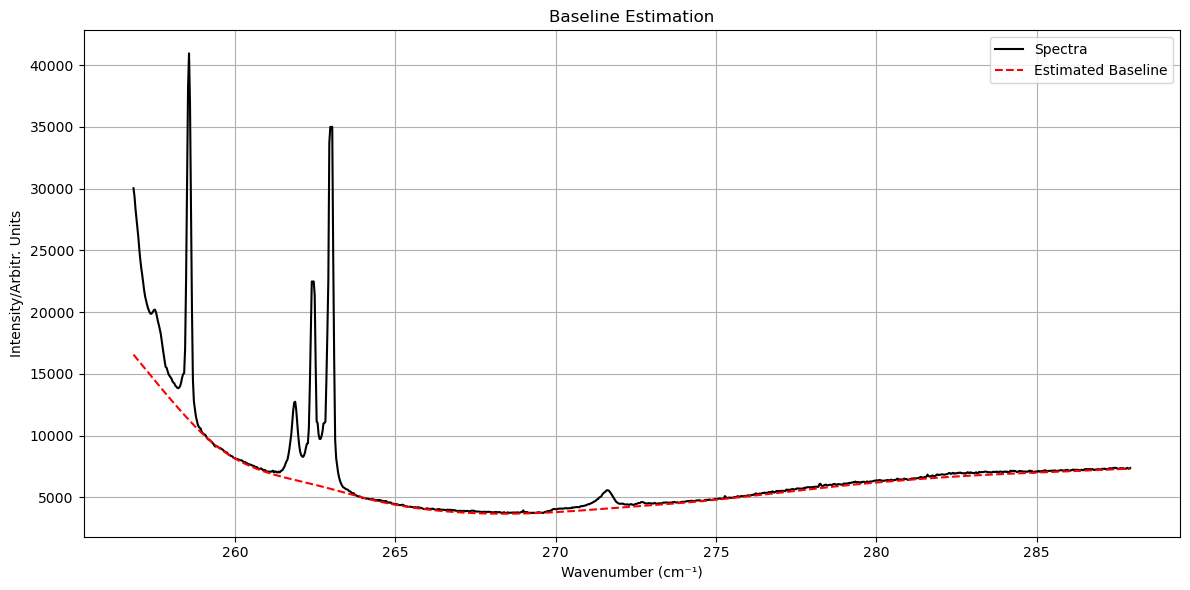

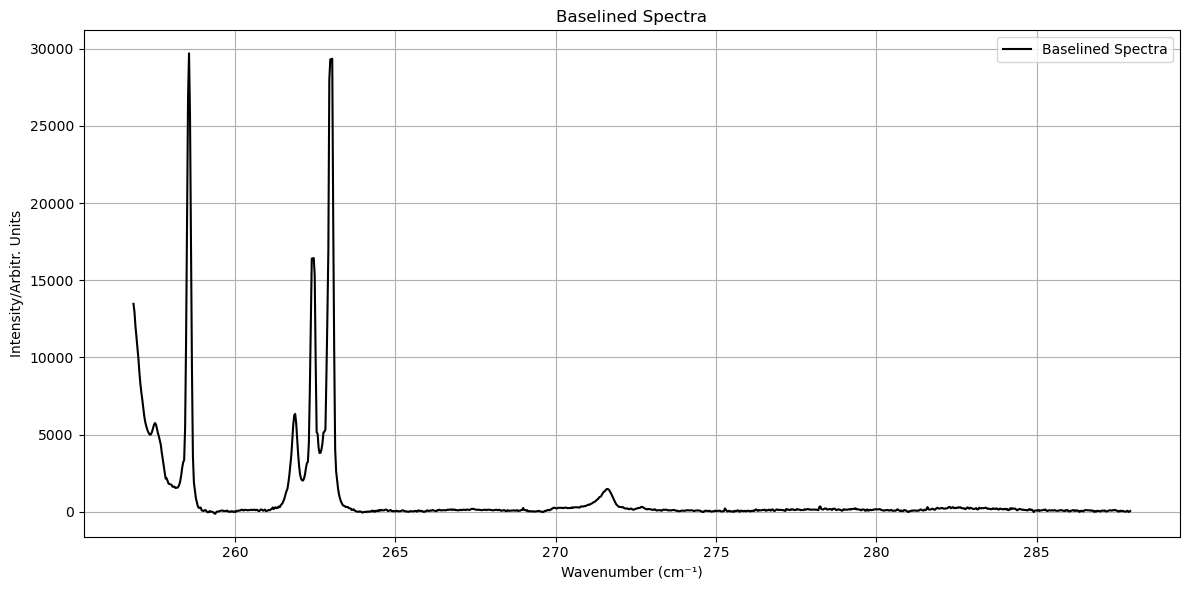

In [7]:
teflon_baselined = ra.estimate_baseline(teflon_averaged, lam=10000, p=0.0005, niter=20, plot=True)

# 8. Cutting the Spectrum to a Region of Interest
We sometimes only need a certain wavenumber region. For example, if we only want 
the region from 258 cm⁻¹ to 265 cm⁻¹, we can use the `cut_spectra` function. 
This can be especially useful if you know the approximate position of important peaks.


/Users/mykytakizilov/Dropbox/projects/BMEN/Raman-Spectra-Analyzer/RamanAnalyzer.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


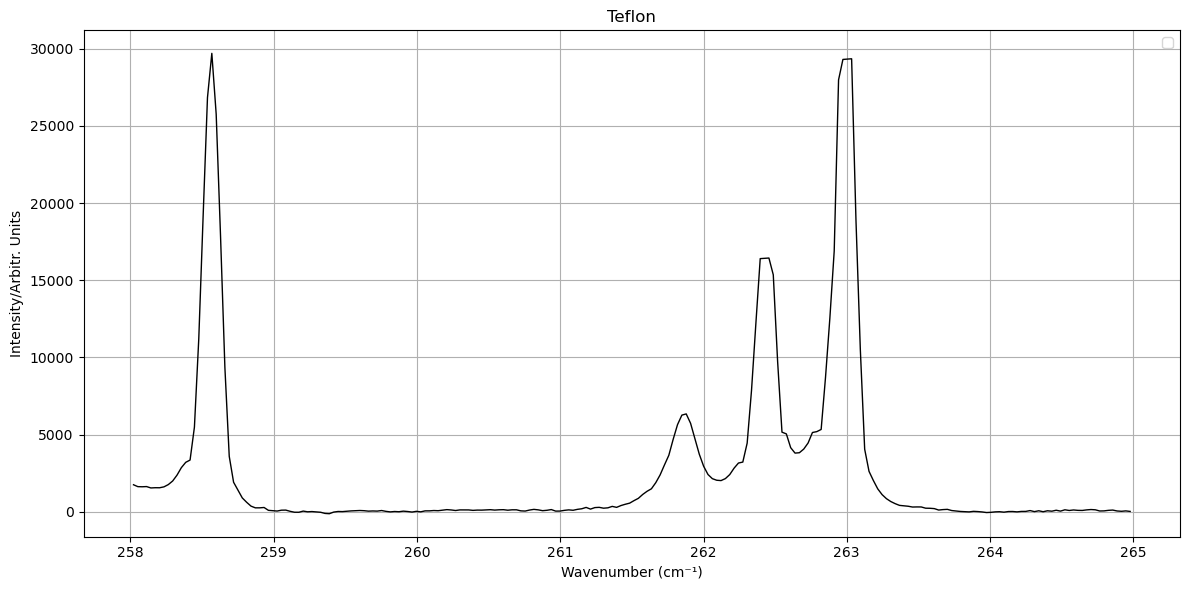

In [8]:
teflon_cutted = ra.cut_spectra(teflon_baselined, 258, 265)
ra.plot_raman(teflon_cutted, 'Teflon')

# 9. Converting Wavelength to Wavenumber
If our data was collected in nanometers (wavelength), but we want wavenumbers (cm⁻¹), 
we can convert them using `convert_wavelength_to_wavenumber`. 
We must supply our laser excitation wavelength in nm. 
In this example, it is 253.6 nm.


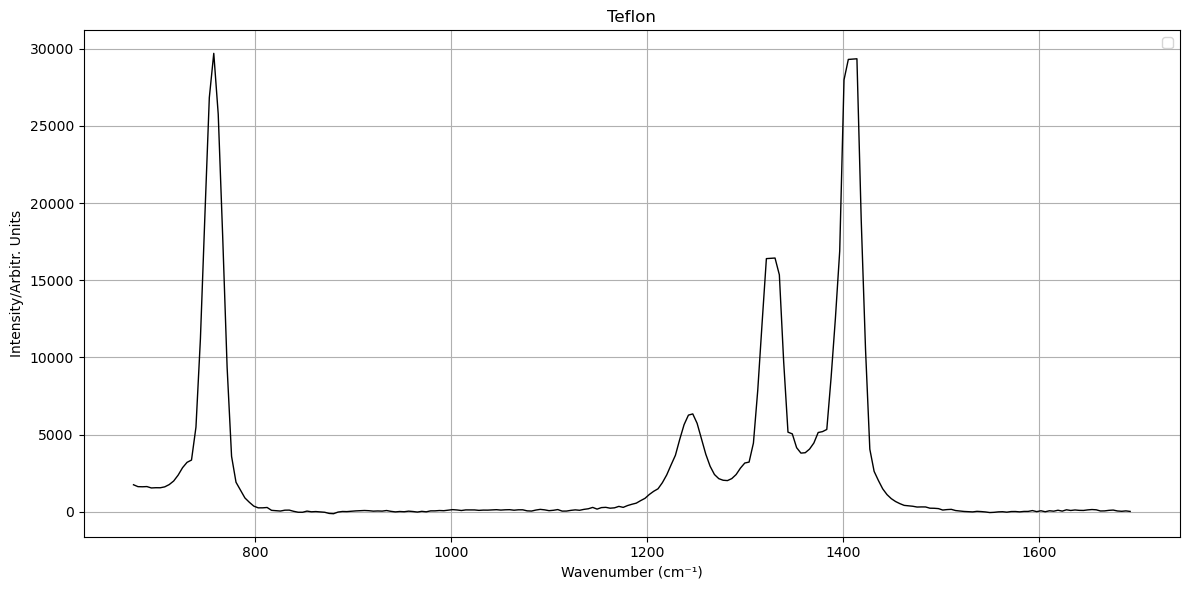

In [9]:
teflon_wavenumber = ra.convert_wavelength_to_wavenumber(teflon_cutted, 253.6)
ra.plot_raman(teflon_wavenumber, 'Teflon')

# 10. Fitting Voigt Profiles
Finally, we fit Voigt peaks to the (optionally) baseline-corrected Teflon spectrum. 
- `threshold`: Minimum intensity for peak detection.
- `min_dist`: Minimum distance (in x-coordinates) between peaks.
- `min_height`: Minimum height for a peak to be considered significant.
- `prominence`: Controls how large a peak should be to stand out from the background.
- `center_vary`: How far the center of a detected peak can shift during fitting.

`max_iterations=0` indicates we don't want additional peaks added from the residual analysis. 
If you set a higher number, the algorithm will iteratively detect peaks in the residual 
and refit until no significant peaks remain.

We also enable `plot=True` and `verbose=True` to visualize the fits and see the fitting report.


Extracting data...
Detecting peaks in the data...
Found 14 peaks in the data.
Starting initial fitting with method 'leastsq'...
[[Model]]
    (((((((((((((Model(voigt, prefix='p0_') + Model(voigt, prefix='p1_')) + Model(voigt, prefix='p2_')) + Model(voigt, prefix='p3_')) + Model(voigt, prefix='p4_')) + Model(voigt, prefix='p5_')) + Model(voigt, prefix='p6_')) + Model(voigt, prefix='p7_')) + Model(voigt, prefix='p8_')) + Model(voigt, prefix='p9_')) + Model(voigt, prefix='p10_')) + Model(voigt, prefix='p11_')) + Model(voigt, prefix='p12_')) + Model(voigt, prefix='p13_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16902
    # data points      = 230
    # variables        = 56
    chi-square         = 97188961.0
    reduced chi-square = 558557.247
    Akaike info crit   = 3091.44033
    Bayesian info crit = 3283.97277
    R-squared          = 0.98768480
##  Warning: uncertainties could not be estimated:
    p1_gamma:       at boundary
    p2_amplitude:   a

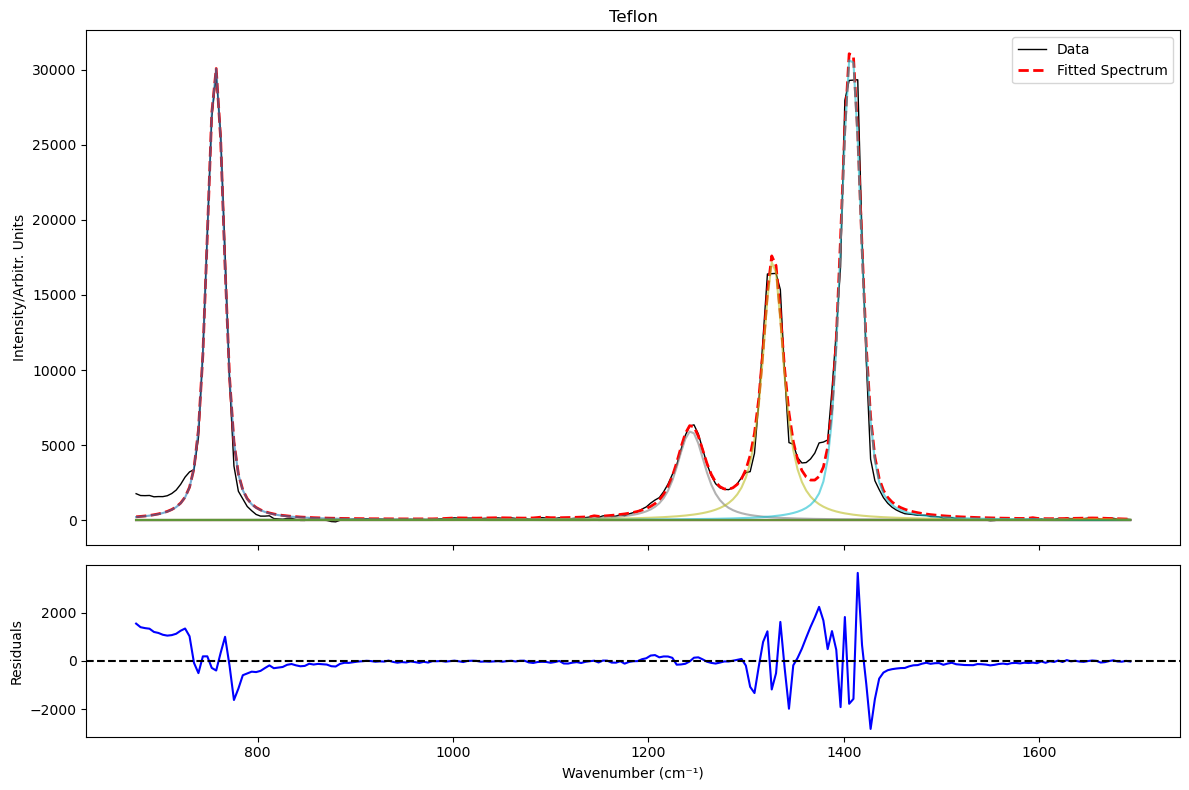

In [12]:
fit_result = ra.fit_voigts(
    teflon_wavenumber,
    title='Teflon',
    threshold=50,
    min_dist=5,
    min_height=50,
    prominence=50,
    reduce_data_points_factor=None,
    plot=True,
    max_iterations=0,
    center_vary=100,
    fit_method='leastsq',
    verbose=True
)

# 11. Summary of the Workflow
1. **Parse** the CSV file to obtain a list of DataFrames.
2. **Despike** each DataFrame to remove cosmic rays/spikes.
3. **Average** multiple despiked DataFrames to improve SNR.
4. **Baseline-correct** the averaged spectrum.
5. **Cut** to a region of interest if necessary.
6. **Convert wavelength to wavenumber** if the x-axis is in nm.
7. **Fit Voigt peaks** to characterize the Raman bands. 

With this pipeline, we can effectively clean up and analyze Teflon Raman spectra, 
or any other materials we are studying, using the built-in functions from `RamanAnalyzer`.
